# Démonstration - Random Forest

## Importation des librairies

In [1]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt

## Importation du modèle, du scaler et des encoders

In [2]:
# Load the model
model = joblib.load('./model.joblib')

# Load the scaler
scaler = joblib.load('./scaler.joblib')

# Load the label_encoders
label_encoders = joblib.load('./label_encoders.joblib')

## Préparation des données

In [3]:
def hex_to_int(hex_val):
    if str(hex_val) in ['nan', 'None']:
        return 0
    return int(str(hex_val), 16)

def apply_hex_conversion(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].apply(hex_to_int)
    return df

def label_encode_categorical_features(df, list_columns):
    for idx, column in enumerate(list_columns):
        if df[column].dtype == 'object':
            try:
                df[column] = label_encoders[idx].transform(df[column].astype(str))
            except:
                df[column] = 0
    return df

def fill_missing_values(df):
    return df.astype(float).fillna(0)

def normalize_numerical_columns(df, numerical_cols):
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    return df

# Columns to select from the dataset
columns = [
    'behavior.summary.keys',
    'behavior.summary.resolved_apis',
    'behavior.summary.executed_commands',
    'behavior.summary.write_keys',
    'behavior.summary.files',
    'behavior.summary.read_files',
    'behavior.summary.write_files',
    'behavior.summary.delete_files',
    'behavior.summary.mutexes',
    'static.pe.osversion',
    'static.pe.imported_dll_count',
    'static.pe.actual_checksum',
    'static.pe.entrypoint'
]

# Columns to apply hex conversion
hex_columns = [
    'static.pe.actual_checksum',
    'static.pe.entrypoint'
]

# List columns for label encoding
list_columns = [
    'behavior.summary.keys',
    'behavior.summary.resolved_apis',
    'behavior.summary.executed_commands',
    'behavior.summary.write_keys',
    'behavior.summary.files',
    'behavior.summary.read_files',
    'behavior.summary.write_files',
    'behavior.summary.delete_files',
    'behavior.summary.mutexes'
]

# Numerical columns to normalize
numerical_cols = [
    'static.pe.osversion',
    'static.pe.imported_dll_count',
    'static.pe.actual_checksum',
    'static.pe.entrypoint'
]

In [4]:
# Import real data and apply the preprocessing before the prediction
filename = './10_report.json'

with open(filename) as json_data:
    data = json.load(json_data)

malware = pd.json_normalize(data)

malware = malware.rename(columns={
    "target.file.pe.osversion": "static.pe.osversion",
    "target.file.pe.imported_dll_count": "static.pe.imported_dll_count",
    "target.file.pe.actual_checksum": "static.pe.actual_checksum",
    "target.file.pe.entrypoint": "static.pe.entrypoint"
})

malware = malware[columns]

malware = apply_hex_conversion(malware, hex_columns)
malware = label_encode_categorical_features(malware, list_columns)
malware = fill_missing_values(malware)
malware = normalize_numerical_columns(malware, numerical_cols)

# Display information about the malware
malware.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   behavior.summary.keys               1 non-null      float64
 1   behavior.summary.resolved_apis      1 non-null      float64
 2   behavior.summary.executed_commands  1 non-null      float64
 3   behavior.summary.write_keys         1 non-null      float64
 4   behavior.summary.files              1 non-null      float64
 5   behavior.summary.read_files         1 non-null      float64
 6   behavior.summary.write_files        1 non-null      float64
 7   behavior.summary.delete_files       1 non-null      float64
 8   behavior.summary.mutexes            1 non-null      float64
 9   static.pe.osversion                 1 non-null      float64
 10  static.pe.imported_dll_count        1 non-null      float64
 11  static.pe.actual_checksum           1 non-null   

## Prédiction du model

Predicted: Emotet


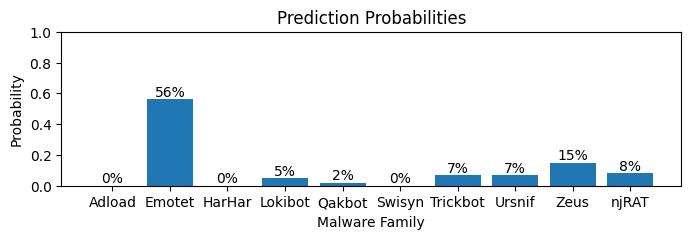

In [5]:
# Predict the malware family
prediction = model.predict(malware)
probabilities = model.predict_proba(malware)

print('Predicted:', prediction[0])
plt.rcParams['figure.figsize'] = [8, 2]
plt.figure()
plt.bar(model.classes_, probabilities[0])
for i, prob in enumerate(probabilities[0]):
    plt.text(i, prob, f'{prob*100:.0f}%', ha='center', va='bottom')
plt.ylim(0, 1)
plt.ylabel('Probability')
plt.xlabel('Malware Family')
plt.title('Prediction Probabilities')
plt.show()